In [520]:
from pybullet_suite import *
from kinjax import *
from jax import jit, vmap
import jax.numpy as jnp
import open3d as o3d
from sampling import *
from conversion import *

In [717]:
# robot config
urdf = "panda.urdf"
ee_link_name = "panda_grasptarget"
world = BulletWorld(gui=False)
panda = world.load_robot(Panda, "panda")
lb, ub = panda.joint_lower_limit, panda.joint_upper_limit
dof = 7
link_dict, joint_dict = get_link_joint_dict(urdf)
fk = get_FK_fn(link_dict, joint_dict, dof, ee_link_name)
fk_batch = get_FK_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)
jac = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name)
jac_batch = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)

argv[0]=
Robot name: panda


In [638]:
q = get_joint(1)
j = jac(q)
1/np.linalg.cond(j[:3, :] @ j[:3, :].T)

0.07255707617214259

In [718]:
# manip with joint limit penalization
def get_manip(joint):
    j = jac_w(joint)
    j = j[:3, :]
    manip = 1/jnp.linalg.cond(j@j.T)
    # manip = jnp.sqrt(jnp.linalg.det(j@j.T))
    # joint_limit_potential = 1/len(joint)/4*jnp.sum((ub-lb)**2/(ub-joint)/(joint-lb))
    # joint_limit_penalty = jnp.exp(1-joint_limit_potential/3)/ jnp.exp(1 - 1/3)
    return manip
get_manip_batch = jax.vmap(get_manip)

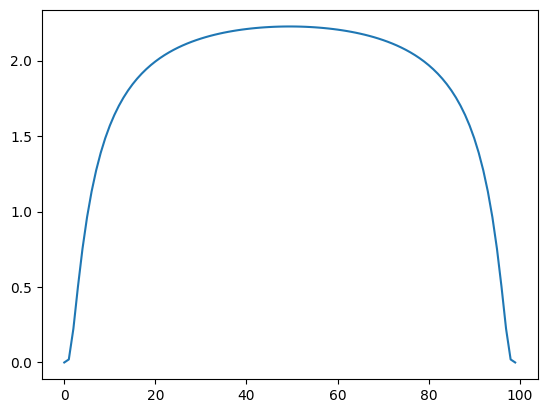

In [719]:
qs = np.linspace(lb+0.001, ub-0.001, 100)
P = []
p = []
for q in qs:
    penalty = float(1/len(q)/4*jnp.sum((ub-lb)**2/(ub-q)/(q-lb)))
    P += [penalty]
    p += [np.exp(1-penalty/5)]
plt.plot(p)

In [720]:
#task_max = np.array([0.017, 0.017, 0.017, 2.5, 2.5, 2.5])
#joint_max = np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])
#W_task = jnp.diag(task_max)
#W_joint = jnp.diag(joint_max)
scale = 2.5/1.7
W_task = jnp.diag(np.array([scale,scale,scale,1,1,1]))
#W_joint = jnp.diag(np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61]))
jac_w = lambda q: W_task @ jac(q)

In [721]:
from scipy.spatial.transform import Rotation
# grids
unit_sphere = generate_uniform_points_on_sphere(1600)
hemisphere = unit_sphere[unit_sphere[:,2] > 0]
xyz_grids = []
for r in np.linspace(0, 1, 21)[1:]:
    xyz_grids.append(hemisphere * r)
xyz_grids = jnp.vstack(xyz_grids)
qtn_grids = jnp.array(generate_qtn_grid(1000))
rot_grids = Rotation.from_quat(qtn_grids).as_matrix()
rot_grids = jnp.array(rot_grids)

#grid functions
def get_xyz_idx(xyz):
    def normal_case(xyz):
        return jnp.argmin(jnp.linalg.norm(xyz_grids - xyz, axis=-1)).astype(int)
    def else_case(xyz):
        return jnp.array(-1)
    negative_z = xyz[-1] < 0
    out_of_range = jnp.linalg.norm(xyz) > 1.
    cond = negative_z | out_of_range
    return jax.lax.cond(cond, else_case, normal_case, xyz)

def get_rot_idx(R):
    acos_input = (jnp.trace(R.T @ rot_grids, axis1=1, axis2=2) - 1.)/2
    acos_input = jnp.clip(acos_input, -1., 1.)
    angles = jnp.arccos(acos_input)
    idx = jnp.argmin(angles).astype(int)
    return idx

def get_idx(xyz, R):
    xyz_idx = get_xyz_idx(xyz)
    rot_idx = get_rot_idx(R)
    return jnp.hstack([xyz_idx, rot_idx])

In [722]:
def get_joint(n):
    if n == 1:
        return np.random.uniform(lb, ub)
    else:
        return np.random.uniform(lb, ub, size=(n,len(lb)))

def get_sample(joint):
    T = fk(joint)
    manip = get_manip(joint)
    xyz, R = T[:3, -1], T[:3, :3]
    Ryinv = R.at[:, 1:].set(-R[:, 1:])
    idx1 = get_idx(xyz, R)
    idx2 = get_idx(xyz, Ryinv)
    return idx1, idx2, manip
get_sample_batch = jax.jit(jax.vmap(get_sample))

In [723]:
def angle_between(rot1, rot2):
    acosinput = (jnp.trace(rot1.T@rot2)-1)/2
    if acosinput <= -1:
        return 180.
    elif acosinput >= 1:
        return 0.
    else:
        return jnp.arccos(acosinput)/np.pi*180.

In [724]:
manip_map = np.zeros((len(xyz_grids), len(rot_grids)))

In [725]:
%load_ext cython
import Cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [588]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

#@cython.boundscheck(False)
#@cython.wraparound(False)
def insert_values(int[:, ::1] idxs, float[::1] manips, float[:,::1] manip_map):
    cdef int updated
    cdef Py_ssize_t n = idxs.shape[0]
    cdef Py_ssize_t x, y, i
    cdef float[:,:] map_view = manip_map
    cdef int[:,:] idxs_view = idxs
    cdef float[:] manips_view = manips
    
    updated = 0
    for i in prange(n, nogil=True):    
        x = idxs_view[i, 0]
        y = idxs_view[i, 1]
        
        #idx, manip in zip(idxs, manips):
        #idx = tuple(idx)
        #if idx[0] < 0 or idx[1] < 0: continue
        if map_view[x, y] < manips_view[i]:
            if map_view[x, y] == 0.: 
                updated += 1
            map_view[x, y] = manips_view[i]
    print(updated)

In [727]:
manip_map = np.array(manip_map).astype(np.float32)
for iter in range(10000):
    updated = 0
    joints = get_joint(100000)
    idx1s, idx2s, manips = get_sample_batch(jnp.array(joints))
    insert_values(np.array(idx1s), np.array(manips), manip_map)
    insert_values(np.array(idx2s), np.array(manips), manip_map)
            
    print(f"iter:{iter}, updated:{updated}")

712
720
iter:0, updated:0
694
692
iter:1, updated:0
702
694
iter:2, updated:0
681
673
iter:3, updated:0
723
712
iter:4, updated:0
743
718
iter:5, updated:0
688
695
iter:6, updated:0
719
698
iter:7, updated:0
708
709
iter:8, updated:0
701
777
iter:9, updated:0
710
689
iter:10, updated:0
754
704
iter:11, updated:0
711
692
iter:12, updated:0
698
656
iter:13, updated:0
688
649
iter:14, updated:0
740
705
iter:15, updated:0
709
695
iter:16, updated:0
709
691
iter:17, updated:0
684
708
iter:18, updated:0
699
743
iter:19, updated:0
735
677
iter:20, updated:0
681
686
iter:21, updated:0
723
627
iter:22, updated:0
710
631
iter:23, updated:0
699
726
iter:24, updated:0
695
683
iter:25, updated:0
687
684
iter:26, updated:0
670
677
iter:27, updated:0
686
641
iter:28, updated:0
637
620
iter:29, updated:0
659
636
iter:30, updated:0
668
708
iter:31, updated:0
643
662
iter:32, updated:0
650
664
iter:33, updated:0
648
655
iter:34, updated:0
651
656
iter:35, updated:0
712
686
iter:36, updated:0
669
657
ite

KeyboardInterrupt: 

In [728]:
manip_map = jnp.array(manip_map)
def get_manip_value(xyz, R):
    xyz_idx = get_xyz_idx(xyz)
    rot_idx = get_rot_idx(R)
    manip = manip_map[xyz_idx, rot_idx]
    return manip
get_manip_value_batch = jax.vmap(get_manip_value, in_axes=(0, None))

In [761]:
import matplotlib.pyplot as plt
def plot_manip_map(z, R):
    x_range = np.linspace(-1, 1, 40, endpoint=True)
    y_range = np.linspace(-1, 1, 40, endpoint=True)
    Xi, Yi = np.meshgrid(x_range, y_range)
    ones = np.ones_like(Xi.reshape(-1,1))
    xyz_batch = jnp.hstack((Xi.reshape(-1,1), Yi.reshape(-1,1), ones*z))
    R = jnp.array(R)
    manips = get_manip_value_batch(xyz_batch, R)
    levels = np.arange(0, 1, 0.1)
    plt.contourf(manips.reshape(40,-1), cmap='jet', levels=levels)
    #plt.imshow(manips.reshape(40, -1), cmap='jet') #, cmap="RdBu"
    print(f"z:{z}, R:{R}")

z:0.4, R:[[ 0.06381729  0.7381261  -0.6716377 ]
 [ 0.08693717  0.66633904  0.74056345]
 [ 0.9941676  -0.10565103 -0.02164664]]


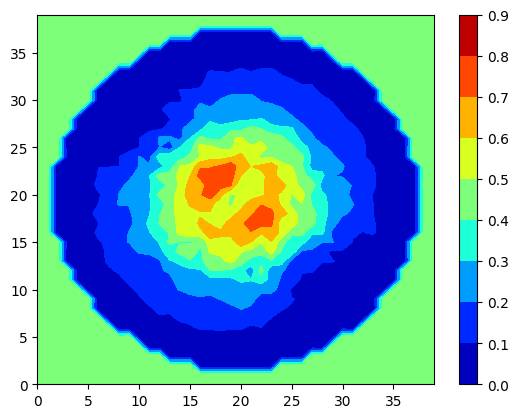

In [803]:
z = 0.4
R = Rotation.random().as_matrix()
plot_manip_map(0.4, R)
plt.colorbar()

z:0.4, R:[[ 0.7960476   0.01436866 -0.6050634 ]
 [-0.18825653  0.95600486 -0.22497587]
 [ 0.5752109   0.29299864  0.7637304 ]]


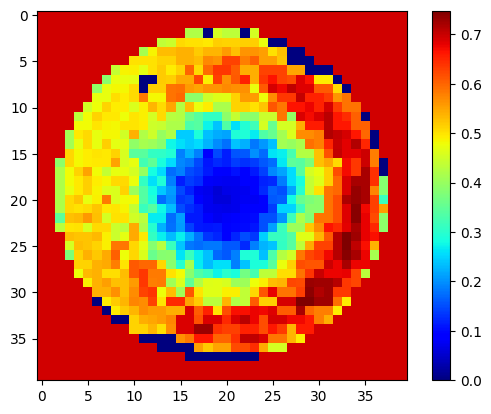

In [716]:
z = 0.4
R = Rotation.random().as_matrix()
plot_manip_map(0.4, R)
plt.colorbar()